# ML for Image Pairs

In [175]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import selenium
from selenium import webdriver 
import urllib.request
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import re
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import shutil

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn import ensemble

In [176]:
arcface = pd.read_csv('ArcFace_Training_Set_Final.csv').drop('Unnamed: 0', axis = 1)
arcface.head()

,Path_1,Path_2,Label,Prediction,Distance,Descriptors_1,Descriptors_2,Matches,Name_1,Name_2,Path_1_Face,Path_2_Face,Descriptors_1_Face,Descriptors_2_Face,Matches_Face
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812,263,578,100,Sheryl_Crow_0008.jpg,Sheryl_Crow_0003.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Sheryl...,88,129,27
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.489551,292,578,89,Sheryl_Crow_0004.jpg,Sheryl_Crow_0003.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Sheryl...,109,129,34
2,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761,263,240,59,Sheryl_Crow_0008.jpg,Luiz_Inacio_Lula_da_Silva_0035.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Luiz_I...,88,114,45
3,/content/drive/MyDrive/all_images_2/Pamela_And...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.938135,411,240,87,Pamela_Anderson_0002.jpg,Luiz_Inacio_Lula_da_Silva_0035.jpg,/content/drive/MyDrive/all_images_faces/Pamela...,/content/drive/MyDrive/all_images_faces/Luiz_I...,71,114,33
4,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842,296,381,89,Hamid_Karzai_0021.jpg,John_Paul_DeJoria_0001.jpg,/content/drive/MyDrive/all_images_faces/Hamid_...,/content/drive/MyDrive/all_images_faces/John_P...,103,140,44


# Variables Analysis

In [177]:
def dist_plot(pos, neg, variable):
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.hist(pos, bins = 40, label = 'Positive', density = True, color = 'blue')
    plt.title(f'Positive {variable}')
    plt.legend()
    plt.subplot(122)
    plt.hist(neg, bins = 40, label = 'Negative', density = True, color = 'red')
    plt.legend()
    plt.title(f'Negative {variable}')
    plt.show()

    plt.figure(figsize = (6,4))
    plt.hist(pos, bins = 40, label = 'Positive', density = True, color = 'blue')
    plt.hist(neg, bins = 40, label = 'Negative', density = True, color = 'red')
    plt.legend()
    plt.title(f'{variable} Comparison')
    plt.show()

In [178]:
def trim(x, n = 1):
    lower = x.mean() - n*x.std()
    upper = x.mean() + n*x.std()
    return x[(x >= lower) & (x <= upper)]

In [179]:
tot = arcface.shape[0]
print('Sample size: ', tot)
print('Accuracy: ', str(len(arcface.loc[(arcface['Label'] == arcface['Prediction']), 'Label'])*100/tot))
print('False Positive: ', str(len(arcface.loc[(arcface['Prediction'] == 1) & (arcface['Label'] == 0), 'Label'])*100/tot))
print('False Negative: ', str(len(arcface.loc[(arcface['Prediction'] == 0) & (arcface['Label'] == 1), 'Label'])*100/tot))

Sample size:  14441
Accuracy:  94.02395955958728
False Positive:  0.9348383075964268
False Negative:  5.041202132816287


## Distances

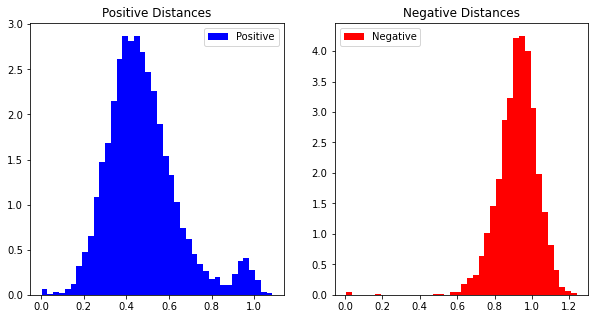

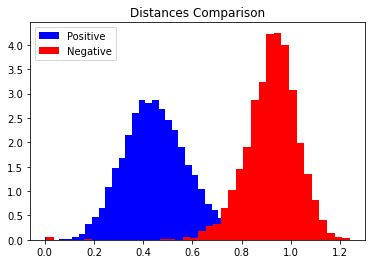

In [131]:
#Normal

pos = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 1), 'Distance'])
neg = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 0), 'Distance'])

dist_plot(pos, neg, 'Distances')

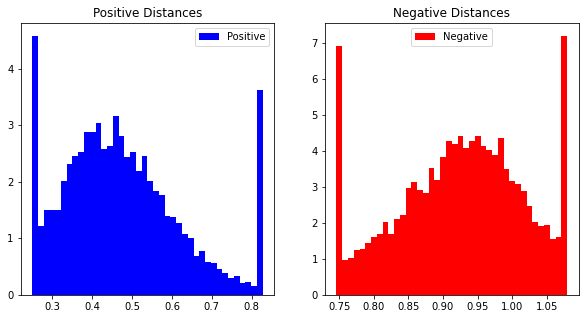

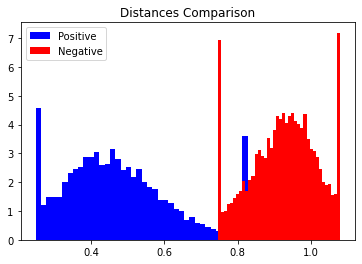

In [132]:
pos = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 1), 'Distance'])
neg = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 0), 'Distance'])

pos = winsorize(pos, limits=[0.05, 0.05])
neg = winsorize(neg, limits = [0.05, 0.05])

dist_plot(pos, neg, 'Distances')

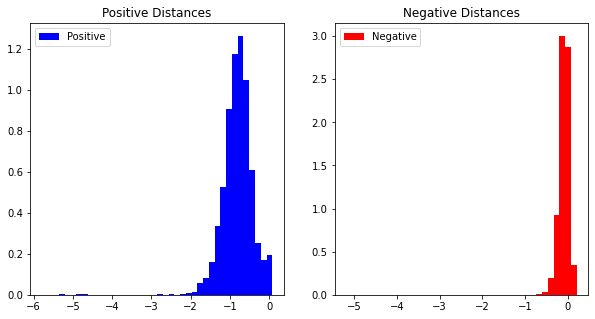

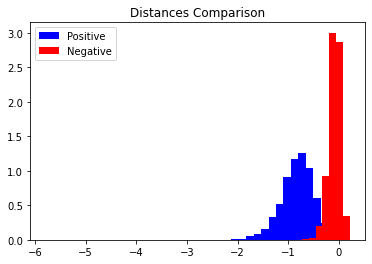

In [133]:
pos = np.log(np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 1), 'Distance']))
neg = np.log(np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 0), 'Distance']))

dist_plot(pos, neg, 'Distances')

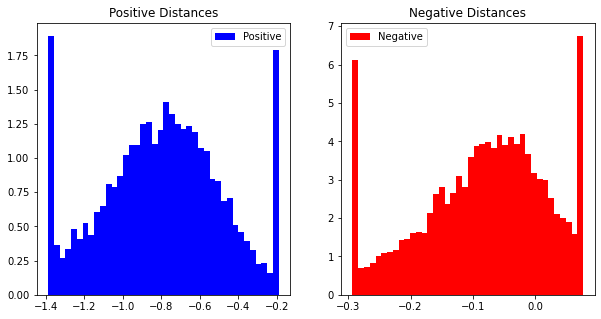

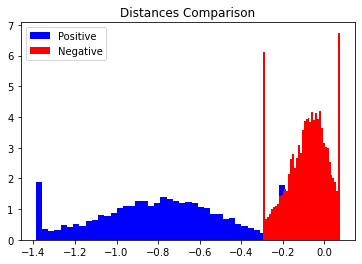

In [134]:
pos = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 1), 'Distance'])
neg = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 0), 'Distance'])

pos = np.log(winsorize(pos, limits=[0.05, 0.05]))
neg = np.log(winsorize(neg, limits = [0.05, 0.05]))

dist_plot(pos, neg, 'Distances')

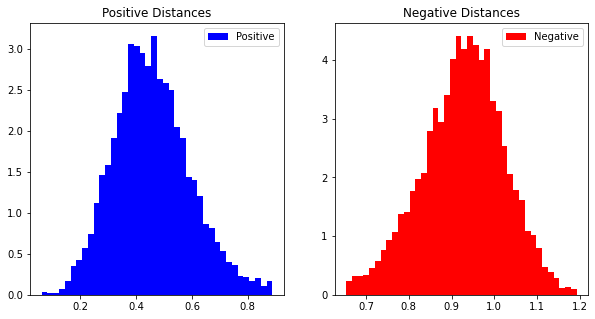

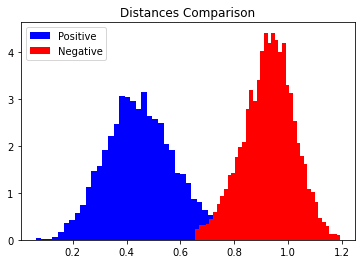

In [135]:
pos = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 1), 'Distance'])
neg = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 0), 'Distance'])

pos = trim(pos, 2.5)
neg = trim(neg, 2.5)

dist_plot(pos, neg, 'Distances')

## SIFT Features

In [151]:
mean_descriptors = [np.mean([arcface.loc[i, 'Descriptors_1'], arcface.loc[i, 'Descriptors_2']]) for i in range(arcface.shape[0])]
arcface['Matches Ratio'] = arcface['Matches']*100/mean_descriptors
arcface.head()

,Path_1,Path_2,Label,Prediction,Distance,Descriptors_1,Descriptors_2,Matches,Matches Ratio
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812,263,578,100,23.781213
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761,263,240,59,23.459245
2,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842,296,381,89,26.292467
3,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Naji_Sabri...,True,True,0.018809,257,530,96,24.396442
4,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Gerhard_Sc...,False,False,0.819620,257,236,74,30.020284


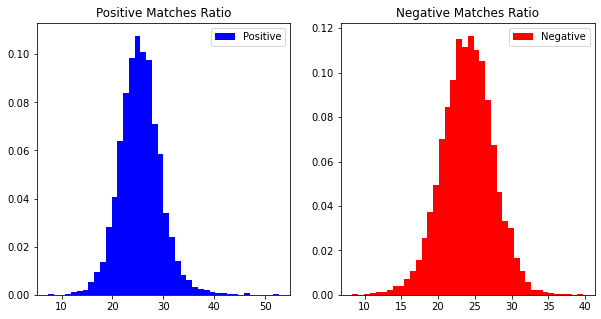

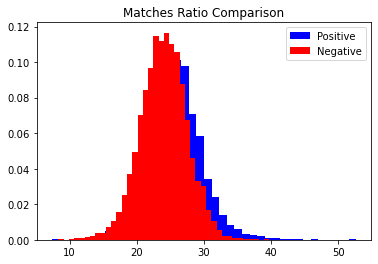

In [152]:
pos = np.array(arcface.loc[arcface['Label'] == 1, 'Matches Ratio'])
neg = np.array(arcface.loc[arcface['Label'] == 0, 'Matches Ratio'])

dist_plot(pos, neg, 'Matches Ratio')

## SIFT Features - Face

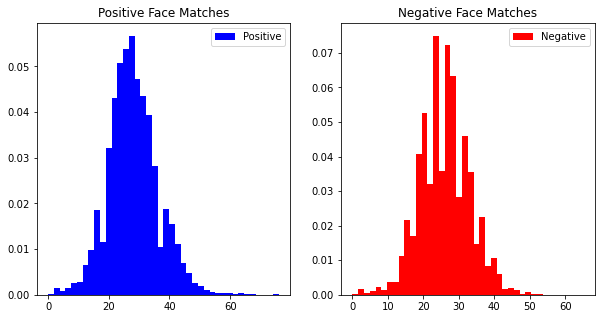

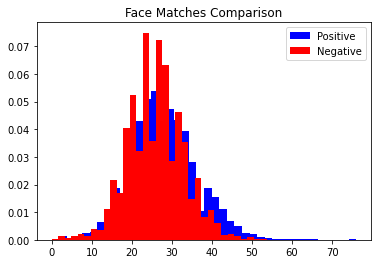

In [180]:
pos = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 1), 'Matches_Face'])
neg = np.array(arcface.loc[(arcface['Distance'].notnull()) & (arcface['Label'] == 0), 'Matches_Face'])

dist_plot(pos, neg, 'Face Matches')

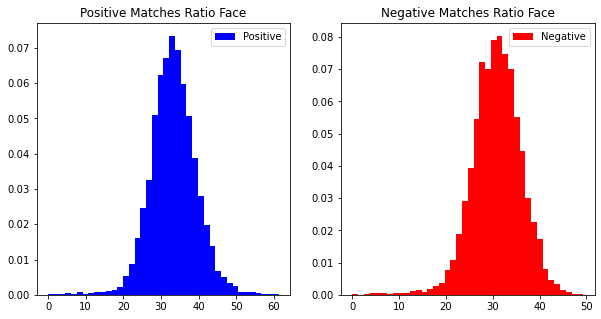

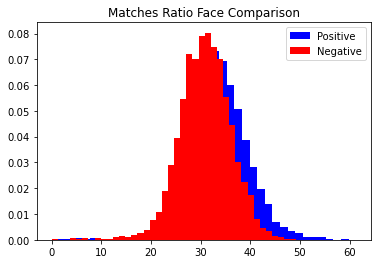

In [181]:
mean_descriptors = [np.mean([arcface.loc[i, 'Descriptors_1_Face'], arcface.loc[i, 'Descriptors_2_Face']]) for i in range(arcface.shape[0])]
arcface['Matches Ratio Face'] = arcface['Matches_Face']*100/mean_descriptors

pos = np.array(arcface.loc[arcface['Label'] == 1, 'Matches Ratio Face'])
neg = np.array(arcface.loc[arcface['Label'] == 0, 'Matches Ratio Face'])

dist_plot(pos, neg, 'Matches Ratio Face')

# Logit

##  SKLearn 

In [35]:
#Logistic Model

x = np.array(arcface.loc[arcface['Distance'].notnull(), 'Distance']).reshape(-1, 1)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

train_portion = 0.7
all_indexes = np.arange(len(y))
train_indexes = np.random.choice(all_indexes, size = int(train_portion*len(y)))
test_indexes = [el for el in all_indexes if el not in train_indexes]

x_train = x[train_indexes]
x_test = x[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

model = LogisticRegression()
model.fit(x_train, y_train)

print('Train Size: ', int(train_portion*len(y)))
print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

Train Size:  10111
Intercept:  [10.21954149]
Coefficient:  [[-14.06671086]]


In [36]:
# Logit Evaluation

preds = model.predict(x_test)
accuracy = len(y_test[y_test == preds])*100/len(y_test)

print('Model Accuracy: ', model.score(x_test, preds))
print('')
print('')
print('Confusion Matrix:')
print(confusion_matrix(y_test, preds))
print('')
print('')
print('Classification Report:')
print(classification_report(y_test, preds))
print('')
print('')
print('Test Accuracy: ', accuracy)

Model Accuracy:  1.0


Confusion Matrix:
[[3443  118]
 [ 275 3326]]


Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.97      0.95      3561
        True       0.97      0.92      0.94      3601

    accuracy                           0.95      7162
   macro avg       0.95      0.95      0.95      7162
weighted avg       0.95      0.95      0.95      7162



Test Accuracy:  94.5127059480592


In [37]:
#Cross Validation
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.943 (0.005)


In [158]:
#Logistic Model - 2 Variables

x = np.array(arcface.loc[arcface['Distance'].notnull(), ['Distance', 'Matches Ratio']]).reshape(-1, 2)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

model = LogisticRegression()
model.fit(x, y)

print('Train Size: ', int(train_portion*len(y)))
print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Train Size:  10111
Intercept:  [9.46270139]
Coefficient:  [[-14.40083566   0.04270431]]
Mean Accuracy: 0.943 (0.005)


## SKLearn + Winsorizing/Trimming/Log

### Winsorizing

In [85]:
x = np.array(arcface.loc[(arcface['Distance'].notnull()), 'Distance'])
x = winsorize(x, limits = [0.5, 0.5]).reshape(-1,1)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

model = LogisticRegression()
model.fit(x, y)

print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Intercept:  [0.00096538]
Coefficient:  [[0.00073358]]
Mean Accuracy: 0.500 (0.000)


### Log Y

In [88]:
x = np.log(np.array(arcface.loc[(arcface['Distance'].notnull()), 'Distance'])).reshape(-1,1)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

model = LogisticRegression()
model.fit(x, y)

print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Intercept:  [-3.34665196]
Coefficient:  [[-9.84915362]]
Mean Accuracy: 0.945 (0.004)


### Trimming

In [94]:
x0 = np.log(np.array(arcface.loc[(arcface['Distance'].notnull()), 'Distance']))
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

x = trim(x0, 2.5)
indexes = [i for i in range(len(x0)) if x0[i] in x]
y = y[indexes]
x = x.reshape(-1,1)

model = LogisticRegression()
model.fit(x, y)

print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Intercept:  [-3.7388799]
Coefficient:  [[-11.38503849]]
Mean Accuracy: 0.945 (0.005)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.33it/s]


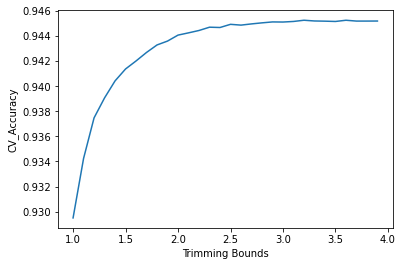

In [119]:
trimmings = np.arange(1,4,0.1)
cv_scores = []
x0 = np.log(np.array(arcface.loc[(arcface['Distance'].notnull()), 'Distance']))
y0 = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

for i in tqdm(range(len(trimmings))):
    n = trimmings[i]
    x = trim(x0, n)
    indexes = [i for i in range(len(x0)) if x0[i] in x]
    y = y0[indexes]
    x = x.reshape(-1,1)
    model = LogisticRegression()
    model.fit(x, y)
    cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
    cv_scores.append(scores.mean())

plt.plot(trimmings, cv_scores)
plt.xlabel('Trimming Bounds')
plt.ylabel('CV_Accuracy')
plt.show()

## SM

In [163]:
# Logit with SM

x = np.array(arcface.loc[arcface['Distance'].notnull(), ['Distance', 'Matches Ratio']]).reshape(-1, 2)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

train_portion = 0.7
all_indexes = np.arange(len(y))
train_indexes = np.random.choice(all_indexes, size = int(train_portion*len(y)))
test_indexes = [el for el in all_indexes if el not in train_indexes]

x_train = x[train_indexes]
x_test = x[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

model = sm.Logit(y_train, x_train)
results = model.fit(method='newton')

results.summary()

Optimization terminated successfully.
         Current function value: 0.201324
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10111
Model:                          Logit   Df Residuals:                    10108
Method:                           MLE   Df Model:                            2
Date:                Fri, 05 May 2023   Pseudo R-squ.:                  0.7094
Time:                        15:42:54   Log-Likelihood:                -2035.6
converged:                       True   LL-Null:                       -7004.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6673      0.357     27.103      0.000       8.968      10.366
x1           -14.9006      0.295    -50.584      0.000     -15.478     -14.323
x2             0.0532      0.012      4.558      0.000       0.030       0.076
==============================================================================
"""

In [164]:
probs = results.predict(x_test)
preds = (probs >= 0.5).astype(int)
accuracy = len(y_test[y_test == preds])*100/len(y_test)
print('Test Accuracy: ', accuracy)

Test Accuracy:  94.42192087236124


# LDA

In [160]:
x = np.array(arcface.loc[arcface['Distance'].notnull(), ['Distance', 'Matches Ratio']]).reshape(-1, 2)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)

scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.943 (0.005)


# Classification Tree

In [187]:
x = np.array(arcface.loc[arcface['Distance'].notnull(), ['Distance', 'Matches Ratio Face']]).reshape(-1,2)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

model = tree.DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)

scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.916 (0.007)


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [02:47<00:00,  1.71s/it]


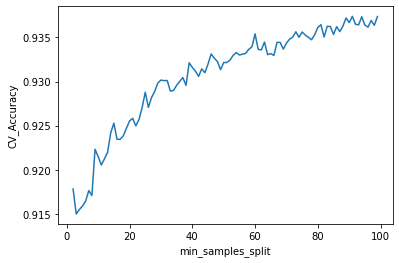

In [162]:
splits = np.arange(2, 100)
cv_scores = []

for i in tqdm(range(len(splits))):
    n = splits[i]
    model = tree.DecisionTreeClassifier(min_samples_split = n)
    cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
    cv_scores.append(scores.mean())
    
plt.plot(splits, cv_scores)
plt.xlabel('min_samples_split')
plt.ylabel('CV_Accuracy')
plt.show()

Feature 0: Score: 97.91739448474344%
Feature 1: Score: 2.0826055152565615%


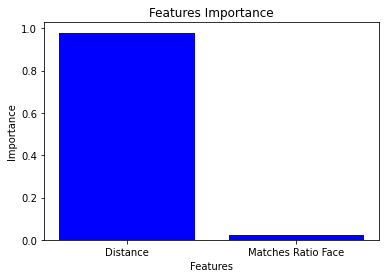

In [188]:
#Features Importance

model = tree.DecisionTreeClassifier(min_samples_split = 100)
model.fit(x, y)
importance = model.feature_importances_

for i,v in enumerate(importance):
    print(f'Feature {i}: Score: {v*100}%')
    
plt.bar(['Distance', 'Matches Ratio Face'], importance, color = 'blue')
plt.title('Features Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Random Forest

In [183]:
x = np.array(arcface.loc[arcface['Distance'].notnull(), ['Distance', 'Matches Ratio Face']]).reshape(-1,2)
y = np.array(arcface.loc[arcface['Distance'].notnull(), 'Label'])

model = ensemble.RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)

scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.944 (0.004)


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:29<00:00, 149.82s/it]


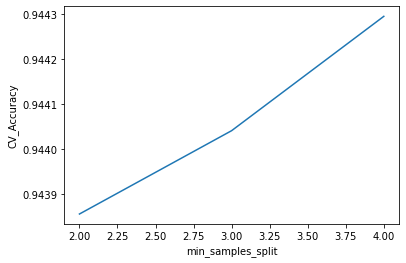

In [174]:
splits = np.arange(2, 5)
cv_scores = []

for i in tqdm(range(len(splits))):
    n = splits[i]
    model = ensemble.RandomForestClassifier()
    cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
    cv_scores.append(scores.mean())
    
plt.plot(splits, cv_scores)
plt.xlabel('min_samples_split')
plt.ylabel('CV_Accuracy')
plt.show()

Feature 0: Score: 90.02416282190208%
Feature 1: Score: 9.975837178097931%


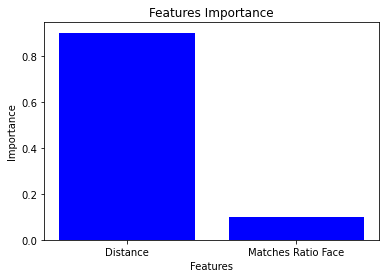

In [185]:
#Features Importance

model = ensemble.RandomForestClassifier()
model.fit(x, y)
importance = model.feature_importances_

for i,v in enumerate(importance):
    print(f'Feature {i}: Score: {v*100}%')
    
plt.bar(['Distance', 'Matches Ratio Face'], importance, color = 'blue')
plt.title('Features Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()